# Classes for creating network

In [ ]:
import torch
from torch import nn

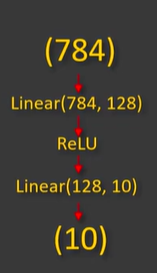

In [ ]:
# 1 variant
class NN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer1 = nn.Linear(input, 128)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(128, output)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        out = self.activation(x)
        return out


    

In [ ]:
# 2 variant
class NN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(input, 128),
                                  nn.ReLU(),
                                  nn.Linear(128, output))
    
    def forward(self, x):
        out = self.model(x)
        return out

In [2]:
######################################################

## ModuleDict() ModuleList()

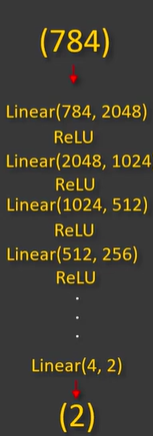

In [6]:
class NN(nn.Module):
    def __init__(self, input, output, hidden_size=2048, activation = 'relu'):
        super().__init__()
        self.activations = nn.ModuleDict({
            'leakyrelyu': nn.LeakyReLU(),
            'relu': nn.ReLU()
        })
        self.layers = nn.ModuleList()
        for i in range(10):
            self.layers.add_module(f"layer_{i}", nn.Linear(input, hidden_size))
            self.layers.add_module(f"activation{i}", self.activations[activation])
            input = hidden_size
            hidden_size = int(hidden_size / 2)
        self.layers.add_module(f"layer_out", nn.Linear(input, output))

        def forward(self, x):
            output = []
            for i, layer in enumerate(self.layers):
                x = layer(x)
                if i != 0 and i % 2 == 0 and i % 4 != 0:
                    output.append(x)
            output.append(x)
            return output



In [8]:
model = NN(784, 2, activation='relu')
model

NN(
  (activations): ModuleDict(
    (leakyrelyu): LeakyReLU(negative_slope=0.01)
    (relu): ReLU()
  )
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=16, bias=True)
    (15): ReLU()
    (16): Linear(in_features=16, out_features=8, bias=True)
    (17): ReLU()
    (18): Linear(in_features=8, out_features=4, bias=True)
    (19): ReLU()
    (20): Linear(in_features=4, out_features=2, bias=True)
  )
)

## Sequential: stack and merge layers

In [9]:
import torch
import torch.nn as nn

def conv_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.BatchNorm2d(out_f),
        nn.ReLU()
    )

class MyCNNClassifier(nn.Module):
    def __init__(self, in_c, n_classes):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(in_c, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Add pooling layer to reduce dimensions
            conv_block(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Add pooling layer to reduce dimensions
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),  # Adjust input dimensions based on pooling
            nn.ReLU(),
            nn.Dropout(0.5),  # Add dropout to prevent overfitting
            nn.Linear(1024, n_classes)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.decoder(x)
        return x


In [12]:
model = MyCNNClassifier(in_c=3, n_classes=10)
print(model)

MyCNNClassifier(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=50176, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


# Merging for classes 

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_channels, out_channels, kernel_size=3, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def dec_block(in_features, out_features):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.ReLU(inplace=True)
    )

class MyEncoder(nn.Module):
    def __init__(self, enc_sizes):
        super(MyEncoder, self).__init__()
        self.conv_blocks = nn.Sequential(*[
            conv_block(in_f, out_f, kernel_size=3, padding=1) 
            for in_f, out_f in zip(enc_sizes, enc_sizes[1:])
        ])

    def forward(self, x):
        return self.conv_blocks(x)
        
class MyDecoder(nn.Module):
    def __init__(self, dec_sizes, n_classes):
        super(MyDecoder, self).__init__()
        self.dec_blocks = nn.Sequential(*[
            dec_block(in_f, out_f) 
            for in_f, out_f in zip(dec_sizes, dec_sizes[1:])
        ])
        self.last = nn.Linear(dec_sizes[-1], n_classes)

    def forward(self, x):
        x = self.dec_blocks(x)
        x = self.last(x)
        return x
    
class MyCNNClassifier(nn.Module):
    def __init__(self, in_c, enc_sizes, dec_sizes, n_classes):
        super(MyCNNClassifier, self).__init__()
        self.enc_sizes = [in_c, *enc_sizes]
        self.dec_sizes = [self.enc_sizes[-1] * 28 * 28, *dec_sizes]

        self.encoder = MyEncoder(self.enc_sizes)
        self.decoder = MyDecoder(self.dec_sizes, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.flatten(1) # Flatten the tensor while preserving the batch dimension
        x = self.decoder(x)
        return x



In [16]:
model = MyCNNClassifier(3, enc_sizes=[32, 64], dec_sizes=[256,128], n_classes=4)
model

MyCNNClassifier(
  (encoder): MyEncoder(
    (conv_blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (decoder): MyDecoder(
    (dec_blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50176, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): ReLU(inplace=True)
      )
    )
    (last): Linear(in_features=128, out_features=4, bias=True)
  )
)

## Skip connection

In [1]:
# Импортируйте PyTorch.
import torch
# Импортируйте модуль nn.
from torch import nn

class BasicBlock(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.fc1 = nn.Linear(input, 10)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(10, output)
        
    def forward(self, x):
        residual = x 
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        out += residual
        out = self.act(out)
        
        return out


class MyModel(nn.Module):
    def __init__(self, input, output, ,internal_input, internal_output):
        super(MyModel, self).__init__()
        self.layers = nn.ModuleList([BasicBlock(internal_input, internal_output) for i in range(10)])
        self.fc = nn.Linear(input, output)
        self.trace = []
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            self.trace.append(x)
            
        out = self.fc(trace)
        return out
        
model = MyModel(5,15)

NameError: name 'layers' is not defined